In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import os
import re
import sys
from datetime import datetime
import memory_profiler
import gc
from multiprocessing import Process
import multiprocessing as mp
import time

sys.path.insert(0, '../../drlib')
import drlib as dr

%matplotlib widget

In [47]:
dataDir = '/drBiggerBoy/drData/Data/'
fileList = os.listdir(dataDir)
fileList.sort(key=lambda f: int(re.sub('\D', '', f)))


In [122]:
#pack "searchable database" df
#indexed by int which counts spectra
#Columns: 
    #File, measData, Date, Temperture, West, Vertical, South, Phi, Theta, VetoSpec(array, len=1e4)

database = pd.read_csv('databaseForPandas.txt', skiprows=0)#False
database['Date'] = pd.to_datetime(database['Date'], infer_datetime_format=True)
database.set_index('Date', inplace=True)
print(database.head())
#database['Rigol'] = 

#print(database.tail())

'''
#pack all veto data into DF
dataDir = '/drBiggerBoy/drData/Data/'
fileList = os.listdir(dataDir)
fileList.sort(key=lambda f: int(re.sub('\D', '', f)))

rigolTempArr = np.zeros((10000, 4))
rigolIdx = 0

for file in fileList[0:5]:
    print(file)
    dataset = h5py.File(dataDir +  file, 'r')
    for measData in dataset:



        datetimeDf     = pd.read_hdf(dataDir + file, key = measData, start=0, stop=1)
        dateTimeStr = datetimeDf.columns[0][0]
        dateTime    = datetime.strptime(dateTimeStr, '%Y-%m-%d %H:%M:%S.%f')


        for key in measDataSubKeys:
            #print(key)
            if key[0] == 'R':
                #print('keys = \n', dataset[measData])
                #rigolTempArr[:,rigolIdx] = dataset[measData][key]
                #print(rigolTempArr)
                rigolIdx += 1
                #print(database[dateTime]) #= np.array(h5py.File(dataDir +  file, 'r')[measData][key])
'''






#check that dates are consecutive
dates = database.index
date_ints = set([d.toordinal() for d in dates])
if max(date_ints) - min(date_ints) == len(date_ints) - 1:
    print("Dates are consecutive")
else:
    raise Exception('Dates are not consecutive')



                         File  measData  Temperature  West  Vertical  South  \
Date                                                                          
2022-07-07 12:46:11.184     0         0       294.35   140       104    200   
2022-07-07 12:47:09.099     0         1       294.35   140       104    200   
2022-07-07 12:48:07.022     0         2       294.35   140       104    200   
2022-07-07 12:49:04.936     0         3       294.35   140       104    200   
2022-07-07 12:50:02.850     0         4       294.35   140       104    200   

                         Phi  Theta  
Date                                 
2022-07-07 12:46:11.184    0     45  
2022-07-07 12:47:09.099    0     45  
2022-07-07 12:48:07.022    0     45  
2022-07-07 12:49:04.936    0     45  
2022-07-07 12:50:02.850    0     45  
Dates are consecutive


In [125]:
database.to_hdf('/drBiggerBoy/drData/run1Data/preProcDataSet.hdf5', 'database_DF')


In [142]:
#f.close()
newDataDir = '/drBiggerBoy/drData/run1Data/'
fileName = 'preProcDataSet.hdf5'
f = h5py.File(newDataDir + fileName, 'r')
#database = f['database_DF']

from numpy import s_
sliceObject = s_['2020-7-7 12:40:00':'2022-7-8 15:19:40 ':None, 
                ]

measDataList = []
for slice in sliceObject:
    #print(slice)
    #print(database[slice])
    measDataListTemp = (database[slice]['measData'].to_list())
    measDataList.extend(measDataListTemp)
#database[sliceObject]['measData']
print('Num measData = ', len(measDataList))

measDataList = np.arange(0, 400, 1)


ti = datetime.now()
diffSpecNew         = np.zeros(int(2**23) -1)
#diffSpecNew         = np.zeros(100)
#diffSpecPackedNew   = np.zeros(int(2**23) -1)
#antSpecNew          = np.zeros(int(2**23)-1)
#termSpecNew         = np.zeros(int(2**23)-1)
for measData in measDataList:
    if measData % 100 == 0:
        print('Currently on measData: ', measData)
    diffSpecNew += (f[str(measData)]['diffSpec_W'])[:]
    #diffSpecPackedNew+=(f[str(measData)]['diffSpec_W'])
    #antSpecNew += (f[str(measData)]['antSpec_fft'])
    #termSpecNew += (f[str(measData)]['termSpec_fft'])
    
    #print(f[str(measData)].attrs['Datetime'])
    #(print('spectrum index = ', measData))



#print(a)
#antSpecNew          /= len(measDataList)
#termSpecNew         /= len(measDataList)
#diffSpecPackedNew   /= len(measDataList)
diffSpecNew         /= len(measDataList)
print('total time =', datetime.now() - ti)

#plt.close('all')
#plt.plot(diffSpecPackedNew)
#print('std = ', np.std(a/len(measDataList)))

Num measData =  1499
Currently on measData:  0
Currently on measData:  100
Currently on measData:  200
Currently on measData:  300
total time = 0:00:17.090463


In [84]:
#Ben's code to convert config file to parsedList and configDic

from collections import namedtuple
from datetime import datetime
from multiprocessing import Pool
import bisect
import configparser
import multiprocessing as mp
import numpy as np
import time
import matplotlib.pyplot as plt 
import h5py as h5
import os
import pandas as pd
import sys

"""
Convert the float parameters in the config file to floats
Parameters:
   aString: The string in the config file
Returns:
    holder (1D list): List of floats
"""
def getFloatBounds(aString):
    holder = aString[aString.index('[')+1:aString.index(']')]
    holder = holder.split(',')
    holder = [float(x) for x in holder]
    if len(holder) % 2 != 0:
        raise Exception('LENGTH OF CONSTRAINT IS NOT A MULTIPLE OF TWO')
    return holder

"""
Convert the date parameters in the config file to floats
Parameters:
   aString: The date string in the config file
Returns:
    holder (1D list): List of datetime objects written as month/day/year hour:minute:second.microseconds
"""
def getDateBounds(aString):
    holder = aString[aString.index('[')+1:aString.index(']')]
    holder = holder.split(',')
    holder = [datetime.strptime(x.strip(), '%m/%d/%Y %H:%M:%S.%f')  for x in holder]
    if len(holder) % 2 != 0:
        raise Exception('LENGTH OF CONSTRAINT IS NOT A MULTIPLE OF TWO')
    return holder

"""
Take in a config file and return a dictionary of bounds
Parameters:
   configFile: The config file
   configName: The name of the configuration setup
Returns:
    configDict (dictionary): Dictionary of bounds
"""
def getAllBounds(configFile, configName):
    configSetup = configparser.ConfigParser()
    configSetup.read(configFile)
    configDict = {}
    tempBounds = getFloatBounds(configSetup[configName]['Temperature'])
    freqBounds = getFloatBounds(configSetup[configName]['Frequency'])
    dateBounds = getDateBounds(configSetup[configName]['Date'])
    antWestBounds =  getFloatBounds(configSetup[configName]['AntennaWest'])
    antVertBounds = getFloatBounds(configSetup[configName]['AntennaVert'])
    antSouthBounds = getFloatBounds(configSetup[configName]['AntennaSouth'])
    antThetaBounds = getFloatBounds(configSetup[configName]['AntennaTheta'])
    antPhiBounds = getFloatBounds(configSetup[configName]['AntennaPhi'])
    measChoice = configSetup['TEST']['Measurement']
    configDict['Temp'] = tempBounds 
    configDict['Freq'] = freqBounds
    configDict['Date'] = dateBounds
    configDict['Ant'] = (antWestBounds, antVertBounds, antSouthBounds, antThetaBounds, antPhiBounds)
    configDict['Choice'] = measChoice
    return configDict

"""
Return the indices in the "database" that fall within the specified
bound. This function assumes that the database is ordered by the 
parameter being searched for.
Parameters:
   val: The value in the config file
   parsedList: List of the parameter being searched for (e.g. date/temperature/antenna position)
Returns:
    holderIndices: List of all the indices in the sorted list that fall in the bounds
"""
def parseOnce(val, parsedList):
    #print('VAL: ' + str(val))
    if len(parsedList) == 0:
        return []
    
    holderIndices = []
    if val[0] > val[1]:
        print('CONFUSED ORDERING')
        return []
    if val[0] == -1:
        startIndex = 0
    elif val[0] < parsedList[0]:
        startIndex = 0
    elif val[0] > parsedList[-1]:
        print('EMPTY LIST')
        return []
    else:
        startIndex = bisect.bisect_left(parsedList, val[0])
    if val[1] == -1:
        endIndex = len(parsedList)
    elif val[1] > parsedList[-1]:
        endIndex = len(parsedList)
    else:
        endIndex = bisect.bisect_right(parsedList, val[1])
    
    [holderIndices.append(x) for x in range(startIndex, endIndex)]    
    return holderIndices

"""
Obtain all the datasets that fall within the bounds given in the config
file.
Parameters:
   configFile: The name of the configuration file
   configName: The name of the configuration setup in the config file 
Returns:
    parsedList: List of all the parsed data files defined as a list of tuples
                of the form ((file number, save number), date, temperature, antenna position).)
                    - Date is a datetime object
                    - Antenna position is a tuple of the form (west, vertical, south, theta, phi)

"""
def getParsedList(configFile, configName):
    #dbFile = '/group/tysongrp/SearchableDatabase.txt'
    dbFile = './SearchableDatabase.txt'

    allData = []
    configDict = getAllBounds(configFile, configName)
    #print('BOUNDS: ' + str(configDict))
    with open(dbFile, 'r') as f:
        f.readline()
        for line in f:
            holder = line.split()
            holder = [x.replace(',', '') if counter > 0 else x for counter, x in enumerate(holder)]
            try:
                dateVal = datetime.strptime(holder[1] + ' ' + holder[2], '%Y-%m-%d %H:%M:%S.%f')
            except:
                 dateVal = datetime.strptime(holder[1] + ' ' + holder[2], '%Y-%m-%d %H:%M:%S')

            tempVal = float(holder[3])
            antPos = (float(holder[4][1:]), float(holder[5]), float(holder[6]), float(holder[7]), float(holder[8][:-1]))
            fileNum = float(holder[0][1:holder[0].index(',')])
            runNum = float(holder[0][holder[0].index(',')+1:-2])
            allData.append(((fileNum, runNum), dateVal, tempVal, antPos))
    
    holderIndices = []
    allData = sorted(allData, key = lambda x: x[1])
    parsedList = allData
    for val in np.reshape(configDict['Date'], (-1, 2)):
        [holderIndices.append(x) for x in parseOnce(val, [x[1] for x in parsedList])]
    
    holderIndices = np.asarray([*set(holderIndices)])
    parsedList = [parsedList[x] for x in holderIndices]
    

# configDict['Ant'] = (antWestBounds, antVertBounds, antSouthBounds, antThetaBounds, antPhiBounds)
# allData.append(((fileNum, runNum), dateVal, tempVal, antPos, antPos))

    for antSortVal in range(len(configDict['Ant'])):
        parsedList = sorted(parsedList, key = lambda x: x[3][antSortVal])
        holderIndices = []
        for val in np.reshape(configDict['Ant'][antSortVal], (-1, 2)):
            [holderIndices.append(x) for x in parseOnce(val, [x[3][0] for x in parsedList])]

        holderIndices = np.asarray([*set(holderIndices)])
        parsedList = [parsedList[x] for x in holderIndices]

    parsedList = sorted(parsedList, key = lambda x: x[2])
    holderIndices = []
    for val in np.reshape(configDict['Temp'], (-1, 2)):
        [holderIndices.append(x) for x in parseOnce(val, [x[2] for x in parsedList])]
    
    holderIndices = np.asarray([*set(holderIndices)])
    parsedList = [parsedList[x] for x in holderIndices]  
    
    parsedList = sorted(parsedList, key=lambda x: (x[0][0], x[0][1]))
    return parsedList, configDict
    #[print(x) for x in parsedList]


In [ ]:
parsedList = getParsedList('ConfigDR.ini', 'TEST')
print('parsedList len = ', len(parsedList[0]))
if len(parsedList[0]) == 1:
    print('only date used : ', (parsedList[0][0][1]))
else:
    print('first date from parsedList : ', (parsedList[0][1][1]))
    print('last date from parsedList : ', (parsedList[0][-1][1]))
print(dataDir)
mySpec = dr.avgSpec(parsedList[0], dataDir, verbose=True)

In [ ]:
termSpec        = mySpec.termData[1:]
antSpec         = mySpec.antData[1:]
diffSpecDrLib   = antSpec - termSpec #fft
#diffSpecNew     = antSpecNew - termSpec #fft
#np.save('termSpecDrLib', termSpec)#
#np.save('antSpecDrLib', antSpec)

In [ ]:
#compare diff spec computed above to the one computed with drlib

#diffSpecPackedNew: watts, from new h5. Packed from OG h5 diff column
#<load>SpecNew:     fft, from new H5
#<load>Spec:        fft, from OG H5, calculated with drlib

#all OG H% data, calculated with drlib
antDataAll  = np.load('./run1_antData_avgAll11776Spectra_gitignore.npy')[1:]
termDataAll = np.load('./run1_termData_avgAll11776Spectra_gitignore.npy')[1:]
oldDiffAll = antDataAll - termDataAll


if 1:
    plt.close('all')
    plt.title('Old Difference Spectrum - New')
    #plt.plot(termSpec - termSpecNew)
    plt.plot(dr.fft2Watts(diffSpecDrLib) - diffSpecNew)
    plt.plot(diffSpecNew)
    #plt.plot(dr.fft2Watts(antSpec - termSpec) - (dr.fft2Watts(antSpecNew) - dr.fft2Watts(termSpecNew)))
    #plt.plot(antSpec - antSpecNew)
    plt.ylabel('Watts')
    plt.xlabel('Index')
    #plt.ylim(-1e-1, 1e-1)

if 0:
    plt.figure()
    plt.title('Difference Spectra')
    plt.plot(dr.fft2Watts(diffSpecDrLib), label = 'Old')
    plt.plot(diffSpecPackedNew, label = 'New', alpha = .5)
    plt.ylabel('Watts')
    plt.xlabel('Index')
    plt.legend(loc = 'upper right')

if 0:
    plt.figure()
    plt.title('Ant Spectra old - new')
    #plt.plot(dr.fft2Watts(antSpec), label = 'old')
    #plt.plot(dr.fft2Watts(antSpecNew), label = 'new')
    plt.plot(dr.fft2Watts(antSpec) - dr.fft2Watts(antSpecNew))
    plt.ylabel('watts')
    plt.xlabel('Index')
    plt.legend(loc = 'upper right')

if 0:
    plt.figure()
    plt.title('Difference Spectra')
    plt.plot(dr.fft2Watts(diffSpecDrLib), label = 'Old')
    plt.plot((diffSpecPackedNew), label = 'New', alpha = .5)
    plt.plot(dr.fft2Watts(diffSpecDrLib) - diffSpecPackedNew, alpha = 1, label = 'Old - New')
    plt.ylabel('Watts')
    plt.xlabel('Index')
    plt.legend(loc = 'upper right')

In [ ]:
idx = 8388606
print('ant spec [%i]        = ' %idx, antSpec[idx])
print('term spec [%i]       = ' %idx, termSpec[idx])
print('diff spec  [%i]      = ' %idx, antSpec[idx] - termSpec[idx])
print()
print('ant spec new [%i]    = ' %idx, antSpecNew[idx])
print('term spec new [%i]   = ' %idx, termSpecNew[idx])
print('diff spec new [%i]   = ' %idx, antSpecNew[idx] - termSpecNew[idx])
print()
print('diff spec new W [%i] = ' %idx, dr.fft2Watts(antSpecNew[idx] - termSpecNew[idx]))
print('diff spec Packed[%i] = ' %idx, diffSpecPackedNew[idx])

In [ ]:
testArr = np.diff(np.asarray(measDataList))
boolArr = testArr != 1
boolArr.sum()

keys = np.asarray([int(key) for key in f.keys()])
print(keys.sum())

print((np.diff(np.sort(keys)) != 1).sum())

temp = 0
for i in range(len(measDataList)):
    temp += i
print(temp)

In [ ]:
#time since start plot
database.iloc[0]

In [ ]:

f = h5py.File('/drBiggerBoy/drData/Data/data_0.h5', 'r')
type(f['measdata_0']['table'][1][1][0])


In [ ]:
f = h5py.File('/drBiggerBoy/drData/run1DataTest/' + fileName, 'r')
keys = f.keys()

for spec in list(keys)[0:1]:
    a = f[spec]['diffSpecWatts'][1]
    print(type(a))
f.close()

In [ ]:
#pack new h5 file 

import h5py

fileName = 'preProcDataSet.hdf5'

try:
    f.close()
except:
    pass

newDataDir = '/drBiggerBoy/drData/run1Data/'
f = h5py.File(newDataDir + fileName, 'r')
numFiles        = 0
numMeasData     = 0
numRigolSpec    = 0

compType = False
chunks = None
########################################
#Main loop
########################################
for file in fileList[0:30]:
    print(file)
    dataset         = h5py.File(dataDir +  file, 'r')
    numFiles        += 1
    measDataKeys    = list(dataset.keys())
    measDataKeys.sort(key=lambda f: int(re.sub('\D', '', f)))

    for measData in measDataKeys:
        measDataSubKeys = dataset[measData].keys()
        #print(measDataSubKeys)
        grp         = f.create_group(str(numMeasData))

        datasetDf   = pd.read_hdf(dataDir + file, key = measData)
        dateTimeStr = datasetDf.columns[0][0]
        dateTime    = datetime.strptime(dateTimeStr, '%Y-%m-%d %H:%M:%S.%f')
        antSpec     = np.asarray(datasetDf.iloc[:,1][1:])
        termSpec    = np.asarray(datasetDf.iloc[:,0][1:])
        diffSpec    = np.float32(dr.fft2Watts(antSpec-termSpec))
        dset        = grp.create_dataset('diffSpec_W', data = diffSpec, compression=compType, chunks=chunks)

        #Testing#####
        if 0:
            diffSpecFFT = np.float32((np.asarray(datasetDf.iloc[:,2][1:])))
            dsetFFT     = grp.create_dataset('diffSpec_fft', data = diffSpecFFT, compression=compType)
            colA        = np.float32((np.asarray(datasetDf.iloc[:,0][1:])))
            dsetA       = grp.create_dataset('termSpec_fft', data = colA, compression=compType)
            colB        = np.float32((np.asarray(datasetDf.iloc[:,1][1:])))
            dsetB       = grp.create_dataset('antSpec_fft', data = colB, compression=compType)
        #############
        
        grp.attrs.create('Datetime', dateTimeStr)
        for attr in database.keys():
            grp.attrs.create(attr, database.loc[dateTime][attr])
        
        

        numMeasData     += 1
        rigolIdx        = 0
        rigolTempArr    = np.zeros((10000,4))
        for key in measDataSubKeys:
            if key[0]=='R':
                rigolTempArr[:, rigolIdx] = dr.dBm2Watts((np.float64(dataset[measData][key])))
                rigolIdx += 1
        rigolMaxArr = np.zeros(10000)
        for i, row in enumerate(rigolTempArr):
            rigolMaxArr[i] = ((row).max())
            
        rigolDest    = grp.create_dataset('rigolSpec_W', data = np.float32(rigolMaxArr), compression=compType)
            
print('number of files = ', numFiles)
print('number of meas data = ', numMeasData)

f.close()

In [7]:
#f.close()
newDataDir = '/drBiggerBoy/drData/run1Data/'
fileName = 'preProcDataSet.hdf5'
f = h5py.File(newDataDir + fileName, 'r')


database = pd.read_hdf(newDataDir+fileName, 'database_DF')


def readTest():
    a = np.zeros(len(f[str(1)]['diffSpec_W'][:]))
    b = np.zeros(len(f[str(1)]['rigolSpec_W'][:]))
    ti = datetime.now()
    for i in range(480):   
        a += f[str(i)]['diffSpec_W'][:]
        b += f[str(i)]['rigolSpec_W'][:]
    return a,b
    print(datetime.now() - ti)


#a,b= readTest()





f.close()

Text(0, 0.5, 'Temperture (k)')

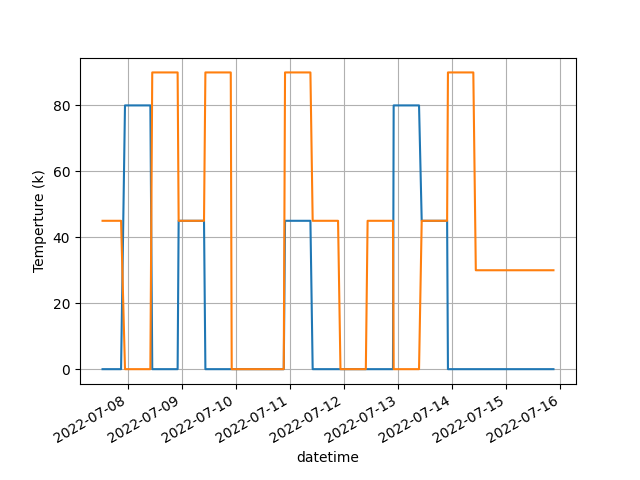

In [44]:
plt.close('all')
#plt.figure()
#plt.scatter(databaseDFasdfa.index, databaseDFasdfa['Temperature'])
#plt.grid()
#plt.xlabel('datetime')
#plt.ylabel('Temperture (k)')

plt.figure()
databaseDFasdfa['Phi'].plot()
databaseDFasdfa['Theta'].plot()

plt.grid()
plt.xlabel('datetime')
plt.ylabel('Temperture (k)')

In [ ]:
plt.close('all')
plt.figure()
plt.plot((dr.watts2dBm(b/480))[1:])
#f

In [120]:
f.close()


In [175]:
#multiprocess h5 read
#needs a little work to make the idxlist, but works pretty well. 
def worker(idxList):
    f = h5py.File('/drBiggerBoy/drData/run1Data/preProcDataSet.hdf5', 'r')
    tempArr = np.zeros(len(f['0']['diffSpec_W']))
    for i in idxList:
        tempArr+=f[str(i)]['diffSpec_W']
    tempArr/=len(idxList)
    return(tempArr)


numFiles = 1000
numProc = 40
idxListAll = np.arange(numFiles)
idxListReshape = idxListAll.reshape(numProc, numFiles//numProc)

with mp.Pool(40) as p:
    arr = p.starmap(worker, (idxListReshape, 'hello'))




TypeError: 'int' object is not iterable

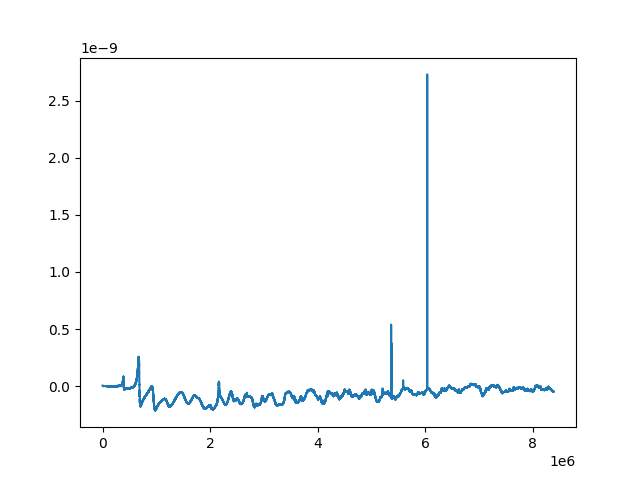

In [158]:
f = h5py.File('/drBiggerBoy/drData/run1Data/preProcDataSet.hdf5', 'r')
avgArr = np.zeros(len(f['0']['diffSpec_W']))

for spec in arr:
    avgArr+=spec
plt.plot(avgArr)

In [165]:
type(avgArr[0])

numpy.float64